# Example of usage Spark OCR for removing text from Dicom images

## Install spark-ocr python packge
Need specify:
- license
- path to `spark-ocr-assembly-[version].jar`
- or `secret` for Spark OCR
- `aws_access_key` and `aws_secret_key`for download pretrained models

For more details about Dicom de-identification please read:

 - [DICOM de-identification at scale in Visual NLP — Part 1.](https://medium.com/john-snow-labs/dicom-de-identification-at-scale-in-visual-nlp-part-1-68784177f5f0)

 - [DICOM de-identification at scale in Visual NLP — Part 2.](https://medium.com/john-snow-labs/dicom-de-identification-at-scale-in-visual-nlp-part-2-361af5e36412)

 - [DICOM de-identification at scale in Visual NLP — Part 3.](https://medium.com/john-snow-labs/dicom-de-identification-at-scale-in-visual-nlp-part-3-ac750be386cb)

In [1]:
license = ""
secret = ""
aws_access_key = ""
aws_secret_key = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../../target/scala-2.12"

In [ ]:
# install from PYPI using secret
# %pip install spark-ocr==$version --extra-index-url=https://pypi.johnsnowlabs.com/$secret --upgrade
# %pip install highdicom

In [ ]:
#%pip install ../../../python/dist/spark-ocr-4.2.1.tar.gz

## Initialization of spark session

In [ ]:
from sparkocr import start
import os
import sys

if license:
    os.environ['JSL_OCR_LICENSE'] = license
    os.environ['SPARK_NLP_LICENSE'] = license

if aws_access_key:
    os.environ['AWS_ACCESS_KEY'] = aws_access_key
    os.environ['AWS_SECRET_ACCESS_KEY'] = aws_secret_key


spark = start(secret=secret,
              jar_path=spark_ocr_jar_path)

spark

## Import Spark OCR transformers

In [3]:
import sparkocr
from sparkocr.transformers import *
from sparkocr.utils import *
from sparkocr.enums import *

from pyspark.ml import PipelineModel, Pipeline

## Define OCR transformers and pipeline

In [4]:
# Distribute images from Dicom(multiframe) to the few partitions
splitter = DicomSplitter() \
    .setInputCol("path") \
    .setOutputCol("frames") \
    .setSplitNumBatch(5) \
    .setPartitionNum(2)

# Extract images from Dicom
dicom_to_image = DicomToImageV2() \
    .setInputCols(["path", "frames"]) \
    .setOutputCol("image") \
    .setKeepInput(True)

# Detect text on the images
text_detector = ImageTextDetectorV2 \
    .pretrained("image_text_detector_v2", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("regions") \
    .setScoreThreshold(0.5) \
    .setTextThreshold(0.2) \
    .setSizeThreshold(10)

# Draw filled rectangle for hide text
draw_regions = DicomDrawRegions() \
    .setInputCol("path") \
    .setInputRegionsCol("regions") \
    .setOutputCol("dicom") \
    .setRotated(True) \
    .setKeepInput(True)

# OCR pipeline
pipeline = PipelineModel(stages=[
     splitter,
     dicom_to_image,
     text_detector,
     draw_regions
])

image_text_detector_v2 download started this may take some time.
Approximate size to download 75.3 MB


## Read dicom objects as binary file and display metadata


In [5]:
import pkg_resources
dicom_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/dicoms/0020.DCM')
dicom_df = spark.read.format("binaryFile").load(dicom_path)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

## Show origina dicom

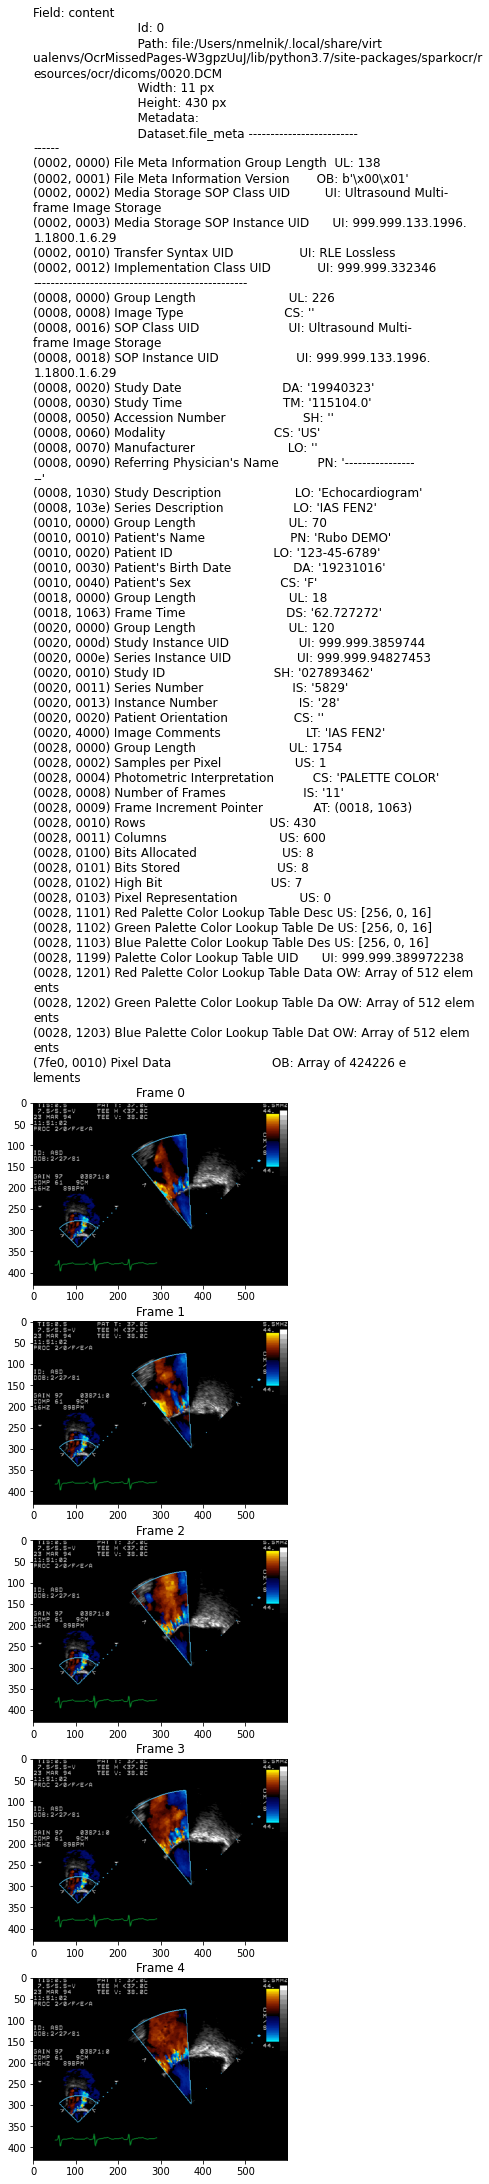

In [6]:
display_dicom(dicom_df, "content")

## Run pipeline and show result

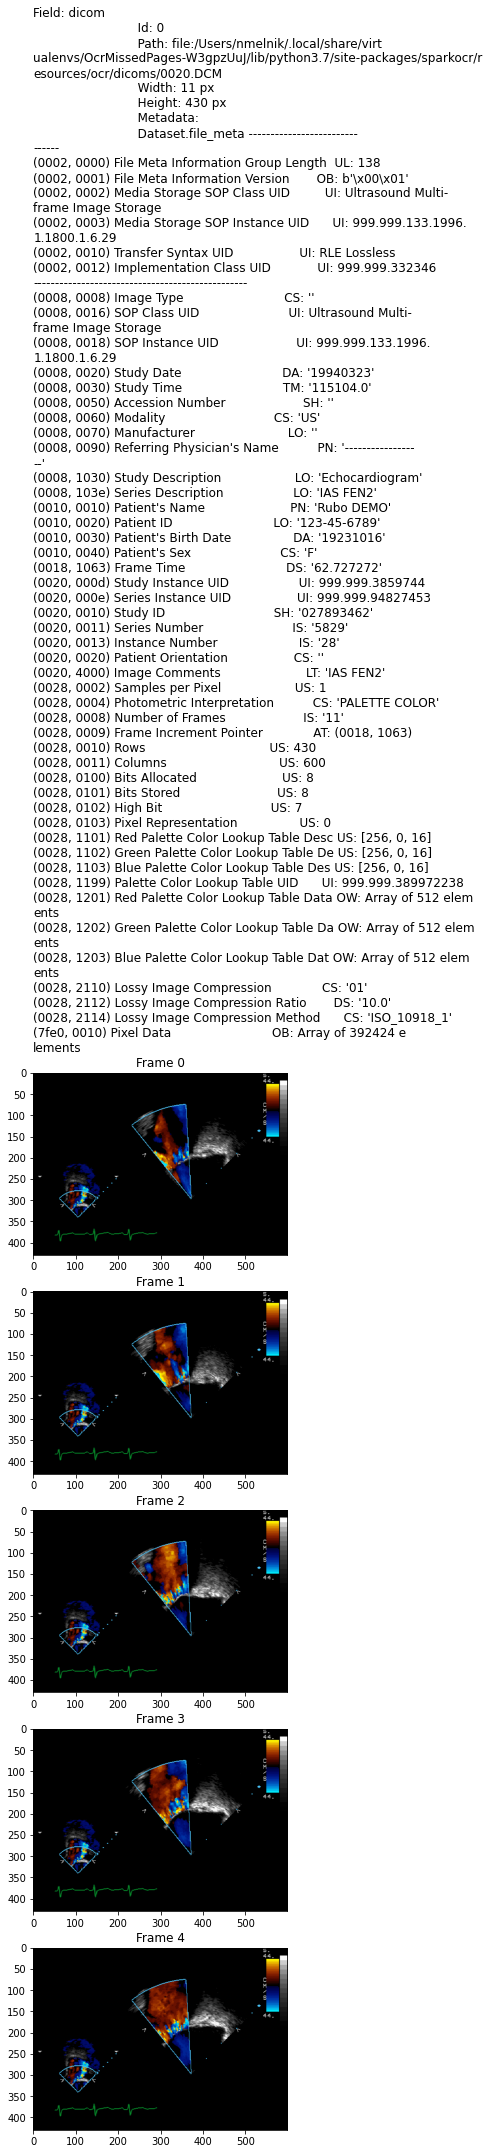

In [7]:
result = pipeline.transform(dicom_df)

display_dicom(result, "dicom")